In [33]:
# Cell 1: Importing Libraries
import numpy as np 
import pandas as pd 
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
import tensorflow as tf
import matplotlib.pyplot as plt

In [34]:
split = 0.85
sequence_length = 8
epochs = 100
learning_rate = 0.01

## Data Preprocessing

In [35]:
# Loading Data
data = pd.read_csv("Data/tsla_data_bis.csv", delimiter=';')
data = data[data['date'] > '2019-01-01']

stock_column = ['Close']
news_column = ['avg_sentiment']

len_data = data.shape[0]


In [36]:
# Splitting Data
train_size = int(len_data * 0.8)
val_size = int(len_data * 0.1)
test_size = len_data - train_size - val_size

train_data = data.get(stock_column).values[:train_size]
train_sentiment = data.get(news_column).values[:train_size]

val_data = data.get(stock_column).values[train_size:train_size+val_size]
val_sentiment = data.get(news_column).values[train_size:train_size+val_size]

test_data = data.get(stock_column).values[train_size+val_size:]
test_sentiment = data.get(news_column).values[train_size+val_size:]

len_train = train_data.shape[0]
len_val = val_data.shape[0]
len_test = test_data.shape[0]


In [37]:
# Normalizing Data
scaler = MinMaxScaler()
train_data = scaler.fit_transform(train_data)
val_data = scaler.transform(val_data)
test_data = scaler.transform(test_data)


In [38]:
# Splitting Training Data to X and Y (Without Sentiment)
X_train_no_sentiment = []
for i in range(len_train - sequence_length):
    X_train_no_sentiment.append(train_data[i : i + sequence_length])
y_train_no_sentiment = np.array(train_data[sequence_length:]).astype(float)

In [39]:
# Splitting Testing Data to X and Y (Without Sentiment)
X_test_no_sentiment = []
for i in range(len_test - sequence_length):
    X_test_no_sentiment.append(test_data[i : i + sequence_length])
y_test_no_sentiment = np.array(test_data[sequence_length:]).astype(float)

In [40]:
# Splitting Training Data to X and Y (With Sentiment)
X_train_with_sentiment = []
for i in range(len_train - sequence_length):
    X_train_with_sentiment.append(train_data[i : i + sequence_length].tolist() + [train_sentiment[sequence_length + i].tolist()])
y_train_with_sentiment = np.array(train_data[sequence_length:]).astype(float)

In [41]:
# Splitting Testing Data to X and Y (With Sentiment)
X_test_with_sentiment = []
for i in range(len_test - sequence_length):
    X_test_with_sentiment.append(test_data[i : i + sequence_length].tolist() + [test_sentiment[sequence_length + i].tolist()])
y_test_with_sentiment = np.array(test_data[sequence_length:]).astype(float)

X_train_with_sentiment = np.array(X_train_with_sentiment).astype(float)
X_test_with_sentiment = np.array(X_test_with_sentiment).astype(float)
X_train_no_sentiment = np.array(X_train_no_sentiment).astype(float)
X_test_no_sentiment = np.array(X_test_no_sentiment).astype(float)

## Model Training

In [42]:
# Creating LSTM Model Function
def model_create(input_shape):
    tf.random.set_seed(1234)
    model = tf.keras.models.Sequential([
        tf.keras.Input(shape=input_shape),
        tf.keras.layers.LSTM(units=70, activation="tanh", return_sequences=True),
        tf.keras.layers.LSTM(units=30, activation="tanh", return_sequences=True),
        tf.keras.layers.LSTM(units=10, activation="tanh", return_sequences=False),
        tf.keras.layers.Dense(units=1, activation="linear")
    ])
    model.compile(
        loss=tf.keras.losses.mean_squared_error,
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate)
    )
    return model

In [43]:
# Training Models
model_no_sentiment = model_create((X_train_no_sentiment.shape[1], 1))
model_with_sentiment = model_create((X_train_with_sentiment.shape[1], 1))

model_no_sentiment.fit(X_train_no_sentiment, y_train_no_sentiment, epochs=epochs)
model_with_sentiment.fit(X_train_with_sentiment, y_train_with_sentiment, epochs=epochs)

Epoch 1/100
25/25 [==============================] - 2s 6ms/step - loss: 0.0244
Epoch 2/100
25/25 [==============================] - 0s 5ms/step - loss: 0.0032
Epoch 3/100
25/25 [==============================] - 0s 5ms/step - loss: 0.0022
Epoch 4/100
25/25 [==============================] - 0s 5ms/step - loss: 0.0018
Epoch 5/100
25/25 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 6/100
25/25 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 7/100
25/25 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 8/100
25/25 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 9/100
25/25 [==============================] - 0s 5ms/step - loss: 0.0014
Epoch 10/100
25/25 [==============================] - 0s 5ms/step - loss: 0.0016
Epoch 11/100
25/25 [==============================] - 0s 5ms/step - loss: 0.0019
Epoch 12/100
25/25 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 13/100
25/25 [=================

## Prediction of stock price

In [44]:
# Prediction on Test Set
def predict(model, X_test):
    predictions = model.predict(X_test)
    predictions = scaler.inverse_transform(predictions.reshape(-1, 1)).reshape(-1, 1)
    return predictions

predictions_no_sentiment = predict(model_no_sentiment, X_test_no_sentiment)
predictions_with_sentiment = predict(model_with_sentiment, X_test_with_sentiment)

# Invert normalization for y_test
y_test = scaler.inverse_transform(y_test_no_sentiment)

3/3 [==============================] - 1s 3ms/step


In [45]:
# Evaluation
def evaluate(predictions, y_test):
    mae = mean_absolute_error(predictions, y_test)
    mape = mean_absolute_percentage_error(predictions, y_test)
    accuracy = 1 - mape
    return mae, mape, accuracy

mae_no_sentiment, mape_no_sentiment, acc_no_sentiment = evaluate(predictions_no_sentiment, y_test)
mae_with_sentiment, mape_with_sentiment, acc_with_sentiment = evaluate(predictions_with_sentiment, y_test)


In [46]:
# Printing Metrics
print(f"Without Sentiment - MAE: {mae_no_sentiment}, MAPE: {mape_no_sentiment}, Accuracy: {acc_no_sentiment}")
print(f"With Sentiment - MAE: {mae_with_sentiment}, MAPE: {mape_with_sentiment}, Accuracy: {acc_with_sentiment}")

Without Sentiment - MAE: 7.335015525650349, MAPE: 0.0354732421724755, Accuracy: 0.9645267578275245
With Sentiment - MAE: 6.727108468059134, MAPE: 0.03219057395844803, Accuracy: 0.967809426041552


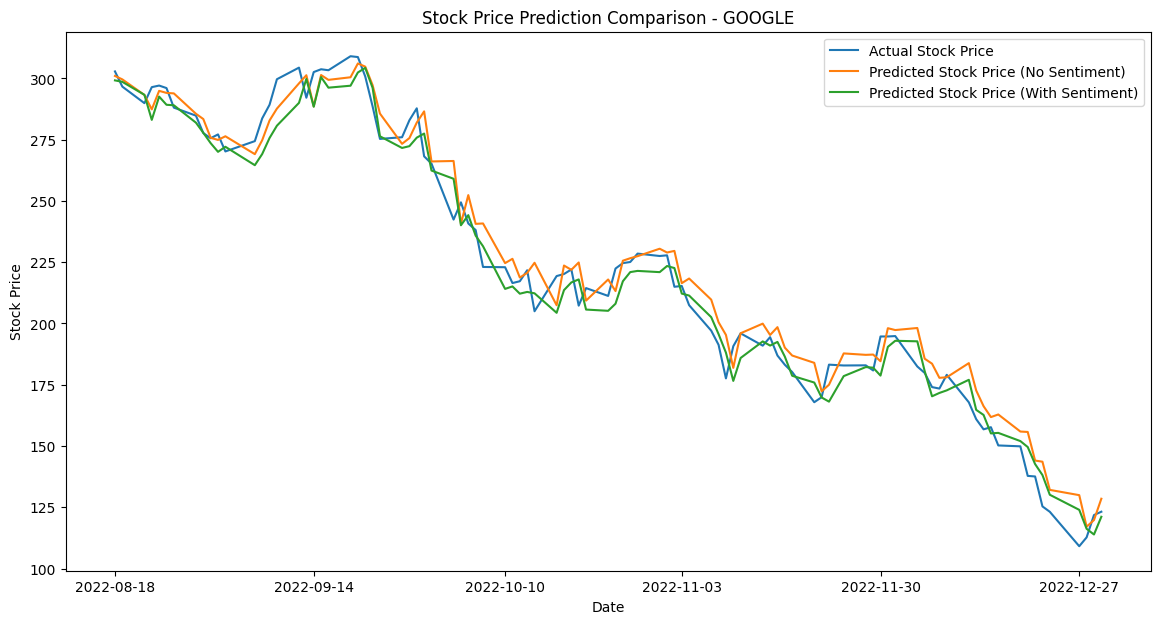

In [47]:

# Extract dates and close prices
dates = pd.to_datetime(data['date'])

# Adjust indices to match y_test and predictions
aligned_dates = dates[-len(y_test):]

# Modify the plotting code
plt.figure(figsize=(14, 7))
plt.plot(aligned_dates, y_test, label='Actual Stock Price')
plt.plot(aligned_dates, predictions_no_sentiment, label='Predicted Stock Price (No Sentiment)')
plt.plot(aligned_dates, predictions_with_sentiment, label='Predicted Stock Price (With Sentiment)')
plt.title('Stock Price Prediction Comparison - GOOGLE')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.xticks(ticks=aligned_dates[::len(aligned_dates)//5], labels=aligned_dates.dt.strftime('%Y-%m-%d')[::len(aligned_dates)//5])
plt.legend()
plt.show()

In [48]:
# Display Metrics Comparison Table
metrics_comparison = pd.DataFrame({
    'Model': ['Without Sentiment', 'With Sentiment'],
    'MAE': [mae_no_sentiment, mae_with_sentiment],
    'MAPE': [mape_no_sentiment, mape_with_sentiment],
    'Accuracy': [acc_no_sentiment, acc_with_sentiment]
})
metrics_comparison


,Model,MAE,MAPE,Accuracy
0,Without Sentiment,7.335016,0.035473,0.964527
1,With Sentiment,6.727108,0.032191,0.967809


## Trading Strategy

In [49]:
returns_with_sentiment = (predictions_with_sentiment[1:] - predictions_with_sentiment[:-1]) / predictions_with_sentiment[:-1]
returns_without_sentiment = (predictions_no_sentiment[1:] - predictions_no_sentiment[:-1]) / predictions_no_sentiment[:-1]

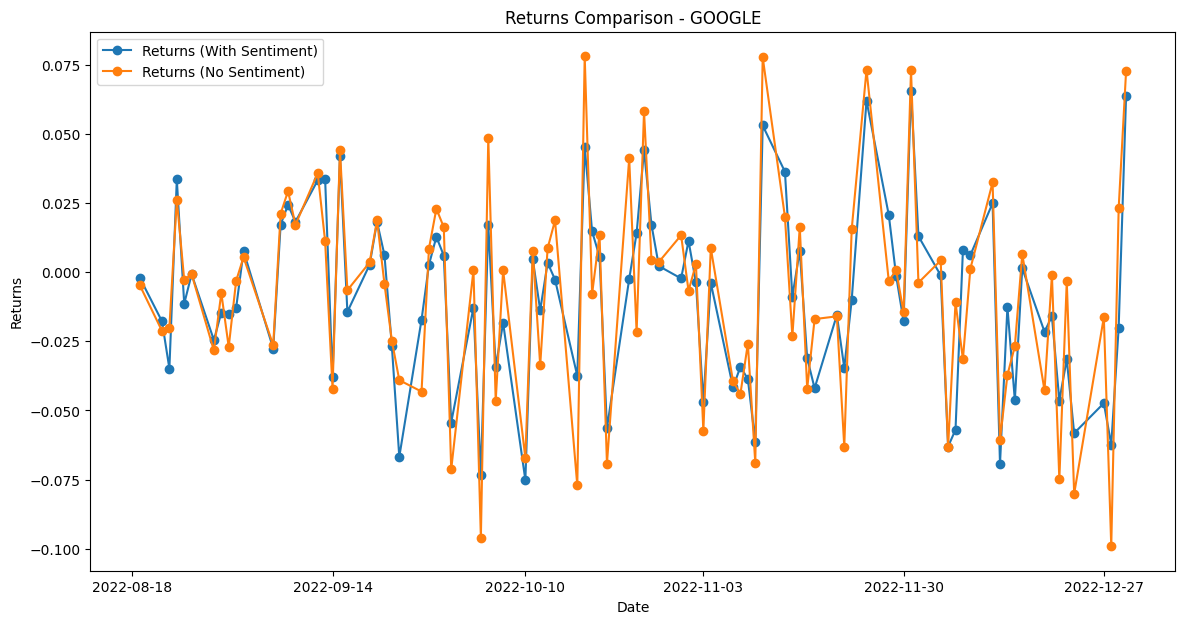

In [50]:
# Adjust dates to match the returns
aligned_dates = dates[-(len(returns_with_sentiment) + 1):]

# Plot the returns
plt.figure(figsize=(14, 7))
plt.plot(aligned_dates[1:], returns_with_sentiment, label='Returns (With Sentiment)', marker='o')
plt.plot(aligned_dates[1:], returns_without_sentiment, label='Returns (No Sentiment)', marker='o')
plt.title('Returns Comparison - GOOGLE')
plt.xlabel('Date')
plt.ylabel('Returns')
plt.xticks(ticks=aligned_dates[::len(aligned_dates)//5], labels=aligned_dates.dt.strftime('%Y-%m-%d')[::len(aligned_dates)//5])
plt.legend()
plt.show()

In [51]:
def compute_strategy_return(predictions, y_test):
    # Start with 1 dollar
    money = 1.0
    
    # Iterate over the predicted and true prices
    for i in range(1, len(predictions)):
        # Current price and predicted price for the next day
        current_price = y_test[i-1]
        next_predicted_price = predictions[i]
        
        # Decision: buy if predicted price is higher, sell if lower
        if next_predicted_price > current_price:
            # We buy the asset (hold the asset)
            money *= y_test[i] / current_price
        elif next_predicted_price < current_price:
            # We sell the asset (not holding the asset)
            money *= current_price / y_test[i]
        # If they are equal, do nothing and continue to next day
        
    return money


strategy_return_with_sentiment = compute_strategy_return(predictions_with_sentiment, y_test)
strategy_return_no_sentiment = compute_strategy_return(predictions_no_sentiment, y_test)

print(f"Return of the strategy with sentiment: {strategy_return_with_sentiment}")
print(f"Return of the strategy without sentiment: {strategy_return_no_sentiment}")

Return of the strategy with sentiment: [1.92759305]
Return of the strategy without sentiment: [0.54730146]


# Hyperparameter optimisation

In [ ]:
# Splitting Training and Validation Data to X and Y (With Sentiment)
def create_sequences(data, sentiment, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        seq_data = data[i:i+seq_length]
        seq_sentiment = np.repeat(sentiment[i+seq_length].reshape(1, -1), seq_length, axis=0)
        combined = np.hstack((seq_data, seq_sentiment))
        X.append(combined)
        y.append(data[seq_length + i])
    return np.array(X).astype(float), np.array(y).astype(float)

X_train_with_sentiment, y_train_with_sentiment = create_sequences(train_data, train_sentiment, sequence_length)
X_val_with_sentiment, y_val_with_sentiment = create_sequences(val_data, val_sentiment, sequence_length)
X_test_with_sentiment, y_test_with_sentiment = create_sequences(test_data, test_sentiment, sequence_length)


In [ ]:
# Grid Search for Hyperparameters
from sklearn.model_selection import ParameterGrid

param_grid = {
    'sequence_length': [5, 8, 10, 15],
    'learning_rate': [0.001, 0.01, 0.2]
}

best_mae = float('inf')
best_params = None

for params in ParameterGrid(param_grid):
    seq_length = params['sequence_length']
    lr = params['learning_rate']
    
    # Create sequences with the current sequence length
    X_train, y_train = create_sequences(train_data, train_sentiment, seq_length)
    X_val, y_val = create_sequences(val_data, val_sentiment, seq_length)
    
    # Create and compile the model
    model = tf.keras.models.Sequential([
        tf.keras.Input(shape=(seq_length, X_train.shape[2])),
        tf.keras.layers.LSTM(units=70, activation="tanh", return_sequences=True),
        tf.keras.layers.LSTM(units=30, activation="tanh", return_sequences=True),
        tf.keras.layers.LSTM(units=10, activation="tanh", return_sequences=False),
        tf.keras.layers.Dense(units=1, activation="linear")
    ])
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
                  loss='mean_absolute_error')
    
    # Train the model
    model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val), verbose=0)
    
    # Evaluate the model on the validation set
    val_pred = model.predict(X_val)
    val_mae = mean_absolute_error(y_val, val_pred)
    
    if val_mae < best_mae:
        best_mae = val_mae
        best_params = params

print(f"Best MAE: {best_mae}, Best Params: {best_params}")
